# Create climatology and persistence forecasts

In this note book we will create the most basic baselines: persistence and climatology forecasts. We will do this for 500hPa geopotential, 850hPa temperature, precipitation and 2 meter temperature.

In [3]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, "/g/data/wb00/admin/testing/weatherbench/notebooks")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from src.score import *

In [3]:
sns.set_style('darkgrid')
sns.set_context('notebook')

## Load data

First, we need to specify the directories and load the data.

In [5]:
res = '5.625'
DATADIR = f'/g/data/wb00/NCI-Weatherbench/{res}deg/'  # Location of WeatherBench dataset
#PREDDIR = '/g/data/wb00/NCI-Weatherbench/baselines/'   # Location to store baseline forecasts
PREDDIR = '/tmp/NCI-Weatherbench/baselines/' 
! mkdir -p {PREDDIR} 

In [5]:
!ls $DATADIR

10m_u_component_of_wind  potential_vorticity	       total_cloud_cover
10m_v_component_of_wind  relative_humidity	       total_precipitation
2m_temperature		 specific_humidity	       u_component_of_wind
constants.nc		 temperature		       v_component_of_wind
geopotential		 toa_incident_solar_radiation  vorticity


In [6]:
xr.open_mfdataset(f'{DATADIR}2m_temperature/*.nc', combine='by_coords', parallel=True)

/opt/conda/envs/mlenv/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/opt/conda/envs/mlenv/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.events-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/opt/conda/envs/mlenv/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


<xarray.Dataset>
Dimensions:  (time: 561024, lat: 32, lon: 64)
Coordinates:
  * time     (time) datetime64[ns] 1959-01-01 ... 2022-12-31T23:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    t2m      (time, lat, lon) float32 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [6]:
%%time
# Load the entire dataset for the relevant variables
#z500 = xr.open_mfdataset(f'{DATADIR}geopotential_500/*.nc', combine='by_coords').z
#t850 = xr.open_mfdataset(f'{DATADIR}temperature_850/*.nc', combine='by_coords').t.drop('level')
z500 = xr.open_mfdataset(f'{DATADIR}geopotential/*.nc', combine='by_coords', parallel=True, chunks={'time': 10}).z.sel(level=500).load()  
t850 = xr.open_mfdataset(f'{DATADIR}temperature/*.nc', combine='by_coords', parallel=True, chunks={'time': 10}).t.sel(level=850).drop('level').load()  


# convert to 6 hourly accumulation
tp = xr.open_mfdataset(f'{DATADIR}total_precipitation/*.nc', combine='by_coords', parallel=True, chunks={'time': 10}).tp.rolling(time=6).sum().load()  
tp.name = 'tp'
t2m = xr.open_mfdataset(f'{DATADIR}2m_temperature/*.nc', combine='by_coords', parallel=True, chunks={'time': 10}).t2m.load()  
data = xr.merge([z500, t850, tp, t2m]).compute()

/opt/conda/envs/mlenv/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/opt/conda/envs/mlenv/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.events-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/opt/conda/envs/mlenv/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


CPU times: user 10min 6s, sys: 13min 22s, total: 23min 29s
Wall time: 1h 11min 20s


In [7]:
%%time
# Load the validation subset of the data: 2017 and 2018
#z500_valid = load_test_data.drop('level')(f'{DATADIR}geopotential_500', 'z')
#t850_valid = load_test_data(f'{DATADIR}temperature_850', 't')
z500_valid = load_test_data(f'{DATADIR}geopotential', 'z')
t850_valid = load_test_data(f'{DATADIR}temperature', 't')

tp_valid = load_test_data(f'{DATADIR}total_precipitation', 'tp').rolling(time=6).sum()
tp_valid.name = 'tp'
t2m_valid = load_test_data(f'{DATADIR}2m_temperature', 't2m')
valid_data = xr.merge([z500_valid, t850_valid, tp_valid, t2m_valid]).compute()

## Persistence

Persistence simply means: Tomorrow's weather is today's weather.

In [8]:
def create_persistence_forecast(ds, lead_time_h):
    assert lead_time_h > 0, 'Lead time must be greater than 0'
    ds_fc = ds.isel(time=slice(0, -lead_time_h))
    return ds_fc

In [12]:
lead_times = xr.DataArray(
    np.arange(6, 126, 6), dims=['lead_time'], coords={'lead_time': np.arange(6, 126, 6)}, name='lead_time')

In [13]:
persistence = []
for l in lead_times:
    persistence.append(create_persistence_forecast(valid_data, int(l)))
persistence = xr.concat(persistence, dim=lead_times)

In [14]:
persistence

<xarray.Dataset>
Dimensions:    (time: 17514, lat: 32, lon: 64, lead_time: 20)
Coordinates:
  * time       (time) datetime64[ns] 2017-01-01 ... 2018-12-31T17:00:00
  * lat        (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon        (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lead_time  (lead_time) int64 6 12 18 24 30 36 42 ... 90 96 102 108 114 120
Data variables:
    z          (lead_time, time, lat, lon) float32 5.095e+04 5.098e+04 ... nan
    t          (lead_time, time, lat, lon) float32 257.8 257.9 257.9 ... nan nan
    tp         (lead_time, time, lat, lon) float32 nan nan nan ... nan nan nan
    t2m        (lead_time, time, lat, lon) float32 248.5 248.1 247.6 ... nan nan

The forecast files have dimensions `[init_time, lead_time, lat, lon]`. Let's now save these files so we can evaluate them later.

In [15]:
# Save the predictions
persistence.to_netcdf(f'{PREDDIR}persistence_{res}.nc')
!ls '{PREDDIR}persistence_{res}.nc'

/tmp/NCI-Weatherbench/baselines/persistence_5.625.nc


## Climatology

First let's create a single climatology from the entire training dataset (meaning everything before 2017).

In [16]:
def create_climatology_forecast(ds_train):
    return ds_train.mean('time')

In [17]:
train_data = data.sel(time=slice(None, '2016'))

In [18]:
climatology = create_climatology_forecast(train_data)

In [19]:
climatology

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64)
Coordinates:
    level    int32 500
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z        (lat, lon) float32 4.886e+04 4.887e+04 ... 5.117e+04 5.118e+04
    t        (lat, lon) float32 241.5 241.7 241.6 241.4 ... 258.7 258.8 258.8
    tp       (lat, lon) float32 2.81e-05 2.708e-05 ... 0.000168 0.0001721
    t2m      (lat, lon) float32 228.5 228.1 227.7 227.5 ... 258.5 258.6 258.7

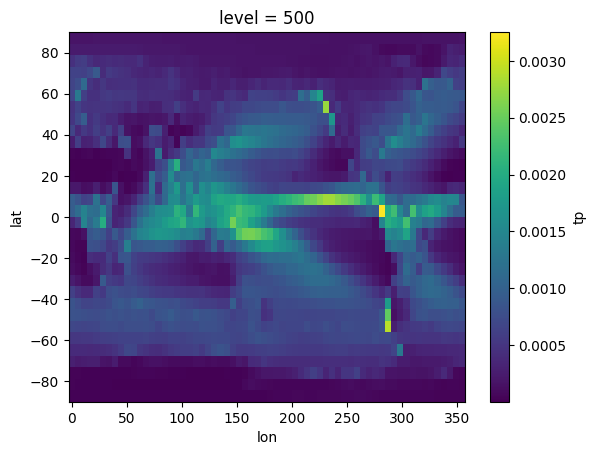

In [21]:
climatology.tp.plot();

In [22]:
climatology.to_netcdf(f'{PREDDIR}climatology_{res}.nc')
!ls '{PREDDIR}climatology_{res}.nc'

/tmp/NCI-Weatherbench/baselines/climatology_5.625.nc


## Climatology by week

We can create amuch better climatology by taking the seasonal cycle into account. Here we will do this by creating a separate climatology for every week.

In [23]:
def create_weekly_climatology_forecast(ds_train, valid_time):
    ds_train['week'] = ds_train['time.week']
    weekly_averages = ds_train.groupby('week').mean('time')
    valid_time['week'] = valid_time['time.week']
    fc_list = []
    for t in valid_time:
        fc_list.append(weekly_averages.sel(week=t.week))
    return xr.concat(fc_list, dim=valid_time)

In [24]:
weekly_climatology = create_weekly_climatology_forecast(train_data, valid_data.time)

/opt/conda/envs/mlenv/lib/python3.9/site-packages/xarray/core/accessor_dt.py:418: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(
/opt/conda/envs/mlenv/lib/python3.9/site-packages/xarray/core/accessor_dt.py:418: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(


In [25]:
weekly_climatology

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 17520)
Coordinates:
    level    int32 500
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
    week     (time) int64 52 52 52 52 52 52 52 52 52 52 ... 1 1 1 1 1 1 1 1 1 1
  * time     (time) datetime64[ns] 2017-01-01 ... 2018-12-31T23:00:00
Data variables:
    z        (time, lat, lon) float32 5.036e+04 5.038e+04 ... 4.981e+04
    t        (time, lat, lon) float32 256.6 256.7 256.6 ... 251.3 251.3 251.3
    tp       (time, lat, lon) float32 1.009e-05 1.028e-05 ... 0.0001167
    t2m      (time, lat, lon) float32 247.2 246.8 246.5 ... 247.5 247.6 247.8

In [26]:
print (f'{PREDDIR}weekly_climatology_{res}.nc')
weekly_climatology.to_netcdf(f'{PREDDIR}weekly_climatology_{res}.nc')
!ls '{PREDDIR}weekly_climatology_{res}.nc'

/tmp/NCI-Weatherbench/baselines/weekly_climatology_5.625.nc
/tmp/NCI-Weatherbench/baselines/weekly_climatology_5.625.nc


# The same for higher resolutions

Not up to date, but previous tests for Z500 and T850 showed that there was only a tiny difference in the scores for different resolutions.

In [ ]:
%%time
for res in ['2.8125','1.40625']:
    #DATADIR = f'/media/rasp/Elements/weather-benchmark/{res}deg/'
    DATADIR = f'/g/data/wb00/NCI-Weatherbench/{res}deg/' 
    # Load the entire dataset
    print (f'loading entire data, res {res}')
    z500 = xr.open_mfdataset(f'{DATADIR}geopotential/*.nc', combine='by_coords', parallel=True).z.sel(level=500)
    t850 = xr.open_mfdataset(f'{DATADIR}temperature/*.nc', combine='by_coords', parallel=True).t.sel(level=850)
    #z500 = xr.open_mfdataset(f'{DATADIR}geopotential/geopotential_201*.nc', combine='by_coords', parallel=True).z.sel(level=500)
    #t850 = xr.open_mfdataset(f'{DATADIR}temperature/temperature_201*.nc', combine='by_coords').t.sel(level=850)
   
    data = xr.merge([z500.drop('level'), t850.drop('level')])
    # Load the validation subset of the data: 2017 and 2018
    print (f'loading validation data, res {res}')
    z500_valid = load_test_data(f'{DATADIR}geopotential', 'z')
    t850_valid = load_test_data(f'{DATADIR}temperature', 't')
    #z500_valid = load_test_data(f'{DATADIR}geopotential/geopotential_201', 'z')
    #t850_valid = load_test_data(f'{DATADIR}temperature/temperature_201', 't')

    valid_data = xr.merge([z500_valid, t850_valid])
    # Persistence forecast
    print("Persistence forecast")
    persistence = []
    for l in lead_times:
        persistence.append(create_persistence_forecast(valid_data, int(l)))
    persistence = xr.concat(persistence, dim=lead_times)
    print(persistence)
    persistence.to_netcdf(f'{PREDDIR}persistence_{res}.nc')
    # Climatology
    train_data = data.sel(time=slice(None, '2016'))
    climatology = create_climatology_forecast(train_data)
    print(climatology)
    climatology.to_netcdf(f'{PREDDIR}climatology_{res}.nc')
    # Weekly climatology
    weekly_climatology = create_weekly_climatology_forecast(train_data, valid_data.time)
    print(weekly_climatology)
    weekly_climatology.to_netcdf(f'{PREDDIR}weekly_climatology_{res}.nc')

loading entire data, res 2.8125
loading validation data, res 2.8125
Persistence forecast
<xarray.Dataset>
Dimensions:    (time: 17514, lat: 64, lon: 128, lead_time: 20)
Coordinates:
  * time       (time) datetime64[ns] 2017-01-01 ... 2018-12-31T17:00:00
  * lat        (lat) float64 -88.59 -85.78 -82.97 -80.16 ... 82.97 85.78 88.59
  * lon        (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * lead_time  (lead_time) int64 6 12 18 24 30 36 42 ... 90 96 102 108 114 120
Data variables:
    z          (lead_time, time, lat, lon) float32 dask.array<chunksize=(1, 8760, 64, 128), meta=np.ndarray>
    t          (lead_time, time, lat, lon) float32 dask.array<chunksize=(1, 8760, 64, 128), meta=np.ndarray>
<xarray.Dataset>
Dimensions:  (lat: 64, lon: 128)
Coordinates:
  * lat      (lat) float64 -88.59 -85.78 -82.97 -80.16 ... 82.97 85.78 88.59
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
Data variables:
    z        (lat, lon) float32 dask.array

# The End